加载特征标 多目标相关性  热力图 模型重要性. 
1. 先选择一个重要的模型找到对目标贡献最大的特征.(找到价值最大的特征们)
2. 然后做共线性 去掉高度相关的重复特征
3. 最后做热力图检查是否有多余 去掉低相关的特征

In [46]:
# %% [markdown]
# # EDA_3_features — 分层筛选，产出最终特征集合（full + core）
# Pipeline:
# 1) 低相关粗筛（可选，基于目标的 Pearson 相关）
# 2) 多目标评估 → 自动选择“最优目标”进行重要性排序
# 3) 基于重要性顺序的相关性剪枝（去冗余）
# 4) 生成 full / core 两套特征清单 + 诊断可视化 + 汇总报告

# %%
import os, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# —— 优先使用 XGBoost；若环境缺失则回退到 RandomForest —— #
try:
    import xgboost as xgb
    USE_XGB = True
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    USE_XGB = False

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# ========= 路径与基本配置 =========
DATA_FEAT_PATH = Path("../data/processed/training_oncourt_features.parquet")
REPORT_DIR     = Path("reports/features")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# 训练禁入列（目标/ID/分组键等）
EXCLUDE_COLS = [
    "salary_usd","log_salary",
    "salary_cap","salary_cap_ratio","log_salary_cap_ratio","salary_cap_equiv",
    "Player_id","season"
]

# 候选目标（会循环评估，自动选择表现最好的作为主目标）
TARGET_CANDIDATES = [
    "salary_usd",
    "log_salary",
    "salary_cap_ratio",
    "log_salary_cap_ratio",
    "salary_cap_equiv",
]

# —— 第1层：与目标的最小相关阈值（粗筛）。设为0则跳过 —— #
MIN_ABS_CORR_TO_TARGET = 0.08

# —— 第3层：剪枝阈值与保留规模 —— #
CORR_THRES = 0.95          # 与已选特征的 |corr| 超过阈值→丢弃（可试 0.90~0.97）
FULL_MAX_KEEP = 40         # full 集合目标规模（30~50 合理）
CORE_MAX_KEEP = 10         # core 集合目标规模（8~12 可解释性版本）

print("USE_XGB =", USE_XGB)

USE_XGB = True


In [47]:
# %%
# ========= 读取数据 =========
df = pd.read_parquet(DATA_FEAT_PATH)
display(df.head(3))
print("shape:", df.shape)

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
feature_cols_all = [c for c in num_cols if c not in EXCLUDE_COLS]
print("Candidate features (before any filtering):", len(feature_cols_all))


,Player_id,season,salary_usd,log_salary,salary_cap,salary_cap_ratio,log_salary_cap_ratio,salary_cap_equiv,Age,GP,...,log1p_FTA,log1p_FTM,log1p_OREB,log1p_DREB,log1p_PF,log1p_Min,log1p_PTS_per_min,log1p_REB_per_min,log1p_AST_per_min,log1p_TOV_per_min
0,1,2020,43006362.0,17.576859,109140000.0,0.394048,0.332212,5.539837e+07,33,63,...,1.987874,1.902108,0.405465,1.791759,1.064711,3.561046,0.660455,0.149126,0.156654,0.094778
1,2,2020,28751775.0,17.174210,109140000.0,0.263439,0.233838,3.703642e+07,28,60,...,2.163323,2.054124,0.788457,1.504077,1.193922,3.605498,0.628236,0.123354,0.115919,0.083046
2,3,2020,31626953.0,17.269520,109140000.0,0.289783,0.254474,4.074006e+07,30,67,...,2.104134,2.041220,0.405465,1.547563,0.916291,3.605498,0.590267,0.110932,0.190205,0.080472


shape: (2082, 90)
Candidate features (before any filtering): 82


In [48]:
# %%
# ========= 工具函数 =========
def plot_small_heatmap(df_sub: pd.DataFrame, title: str):
    corr_m = df_sub.corr(numeric_only=True).values
    labels = list(df_sub.columns)
    fig, ax = plt.subplots(figsize=(max(8, len(labels)*0.5), max(6, len(labels)*0.5)))
    im = ax.imshow(corr_m, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels))); ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels(labels)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

def drop_low_corr_features(df, features, target, thres=0.0):
    """按与目标的最小绝对相关阈值粗筛；thres<=0 时返回原特征集合。"""
    if thres <= 0:
        return features, pd.Series(dtype=float)
    corr_s = df[features + [target]].corr(numeric_only=True)[target].drop(labels=[target], errors="ignore")
    keep = [f for f in features if abs(corr_s.get(f, 0.0)) >= thres]
    drop = sorted(set(features) - set(keep))
    return keep, corr_s.loc[keep].sort_values(ascending=False)

def fit_and_importance(X, y, use_xgb=True, seed=42):
    """拟合模型并返回预测、重要性Series（按降序）。"""
    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=seed)
    if use_xgb:
        dtr = xgb.DMatrix(Xtr, label=ytr)
        dva = xgb.DMatrix(Xva, label=yva)
        params = {
            "objective": "reg:squarederror",
            "max_depth": 6,
            "eta": 0.1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "seed": seed,
        }
        booster = xgb.train(params, dtr, num_boost_round=400, evals=[(dva, "val")],
                            early_stopping_rounds=30, verbose_eval=False)
        pred = booster.predict(dva)
        score_map = booster.get_score(importance_type="gain")
        importances = pd.Series({k: score_map.get(k, 0.0) for k in X.columns}).sort_values(ascending=False)
        model_tag = "XGB"
    else:
        from sklearn.ensemble import RandomForestRegressor
        rf = RandomForestRegressor(n_estimators=600, max_depth=None, random_state=seed, n_jobs=-1)
        rf.fit(Xtr, ytr)
        pred = rf.predict(Xva)
        importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
        model_tag = "RF"
    r2 = r2_score(yva, pred)
    rmse = mean_squared_error(yva, pred, squared=False)
    return pred, importances, r2, rmse, model_tag

def correlation_prune(df, ordered_feats, max_keep=40, corr_thres=0.95):
    """按重要性顺序进行相关性剪枝，返回被选中的特征列表。"""
    selected = []
    for f in ordered_feats:
        if len(selected) == 0:
            selected.append(f)
            if len(selected) >= max_keep: break
            continue
        keep = True
        for g in selected:
            r = np.corrcoef(df[f].fillna(0), df[g].fillna(0))[0, 1]
            if np.isnan(r): r = 0.0
            if abs(r) >= corr_thres:
                keep = False
                break
        if keep:
            selected.append(f)
            if len(selected) >= max_keep: break
    return selected


In [49]:
# %%
# ========= 第0步：多目标评估，自动选主目标 =========
results_summary = []
target_valids = [t for t in TARGET_CANDIDATES if t in df.columns]
assert target_valids, "没有可用的目标列。"

for tgt in target_valids:
    # 可选：先做低相关粗筛（为了公平，先不筛；下一步再在主目标上筛）
    X_all = df[feature_cols_all].copy()
    y_all = df[tgt].copy()
    _, imp, r2, rmse, mtag = fit_and_importance(X_all, y_all, use_xgb=USE_XGB)
    results_summary.append({"target": tgt, "r2": r2, "rmse": rmse, "model": mtag})
    imp.to_csv(REPORT_DIR / f"feature_importance_{tgt}.csv", header=["importance"])
    print(f"[{mtag}] target={tgt}  R²={r2:.4f}  RMSE={rmse:.6f}  (importance saved)")

results_df = pd.DataFrame(results_summary).sort_values("r2", ascending=False)
display(results_df)
best_target = results_df.iloc[0]["target"]
print(f"✅ 自动选择的主目标：{best_target}")

results_df.to_csv(REPORT_DIR / "model_target_metrics.csv", index=False)


[XGB] target=salary_usd  R²=0.7562  RMSE=5686019.887826  (importance saved)
[XGB] target=log_salary  R²=0.5930  RMSE=0.728958  (importance saved)
[XGB] target=salary_cap_ratio  R²=0.7925  RMSE=0.042564  (importance saved)
[XGB] target=log_salary_cap_ratio  R²=0.7694  RMSE=0.039086  (importance saved)
[XGB] target=salary_cap_equiv  R²=0.7914  RMSE=5999411.814884  (importance saved)


,target,r2,rmse,model
2,salary_cap_ratio,0.792458,4.256399e-02,XGB
4,salary_cap_equiv,0.791386,5.999412e+06,XGB
3,log_salary_cap_ratio,0.769382,3.908632e-02,XGB
0,salary_usd,0.756245,5.686020e+06,XGB
1,log_salary,0.593010,7.289579e-01,XGB


✅ 自动选择的主目标：salary_cap_ratio


[Layer-1] 低相关粗筛：从 82 → 74  (阈值=0.08)


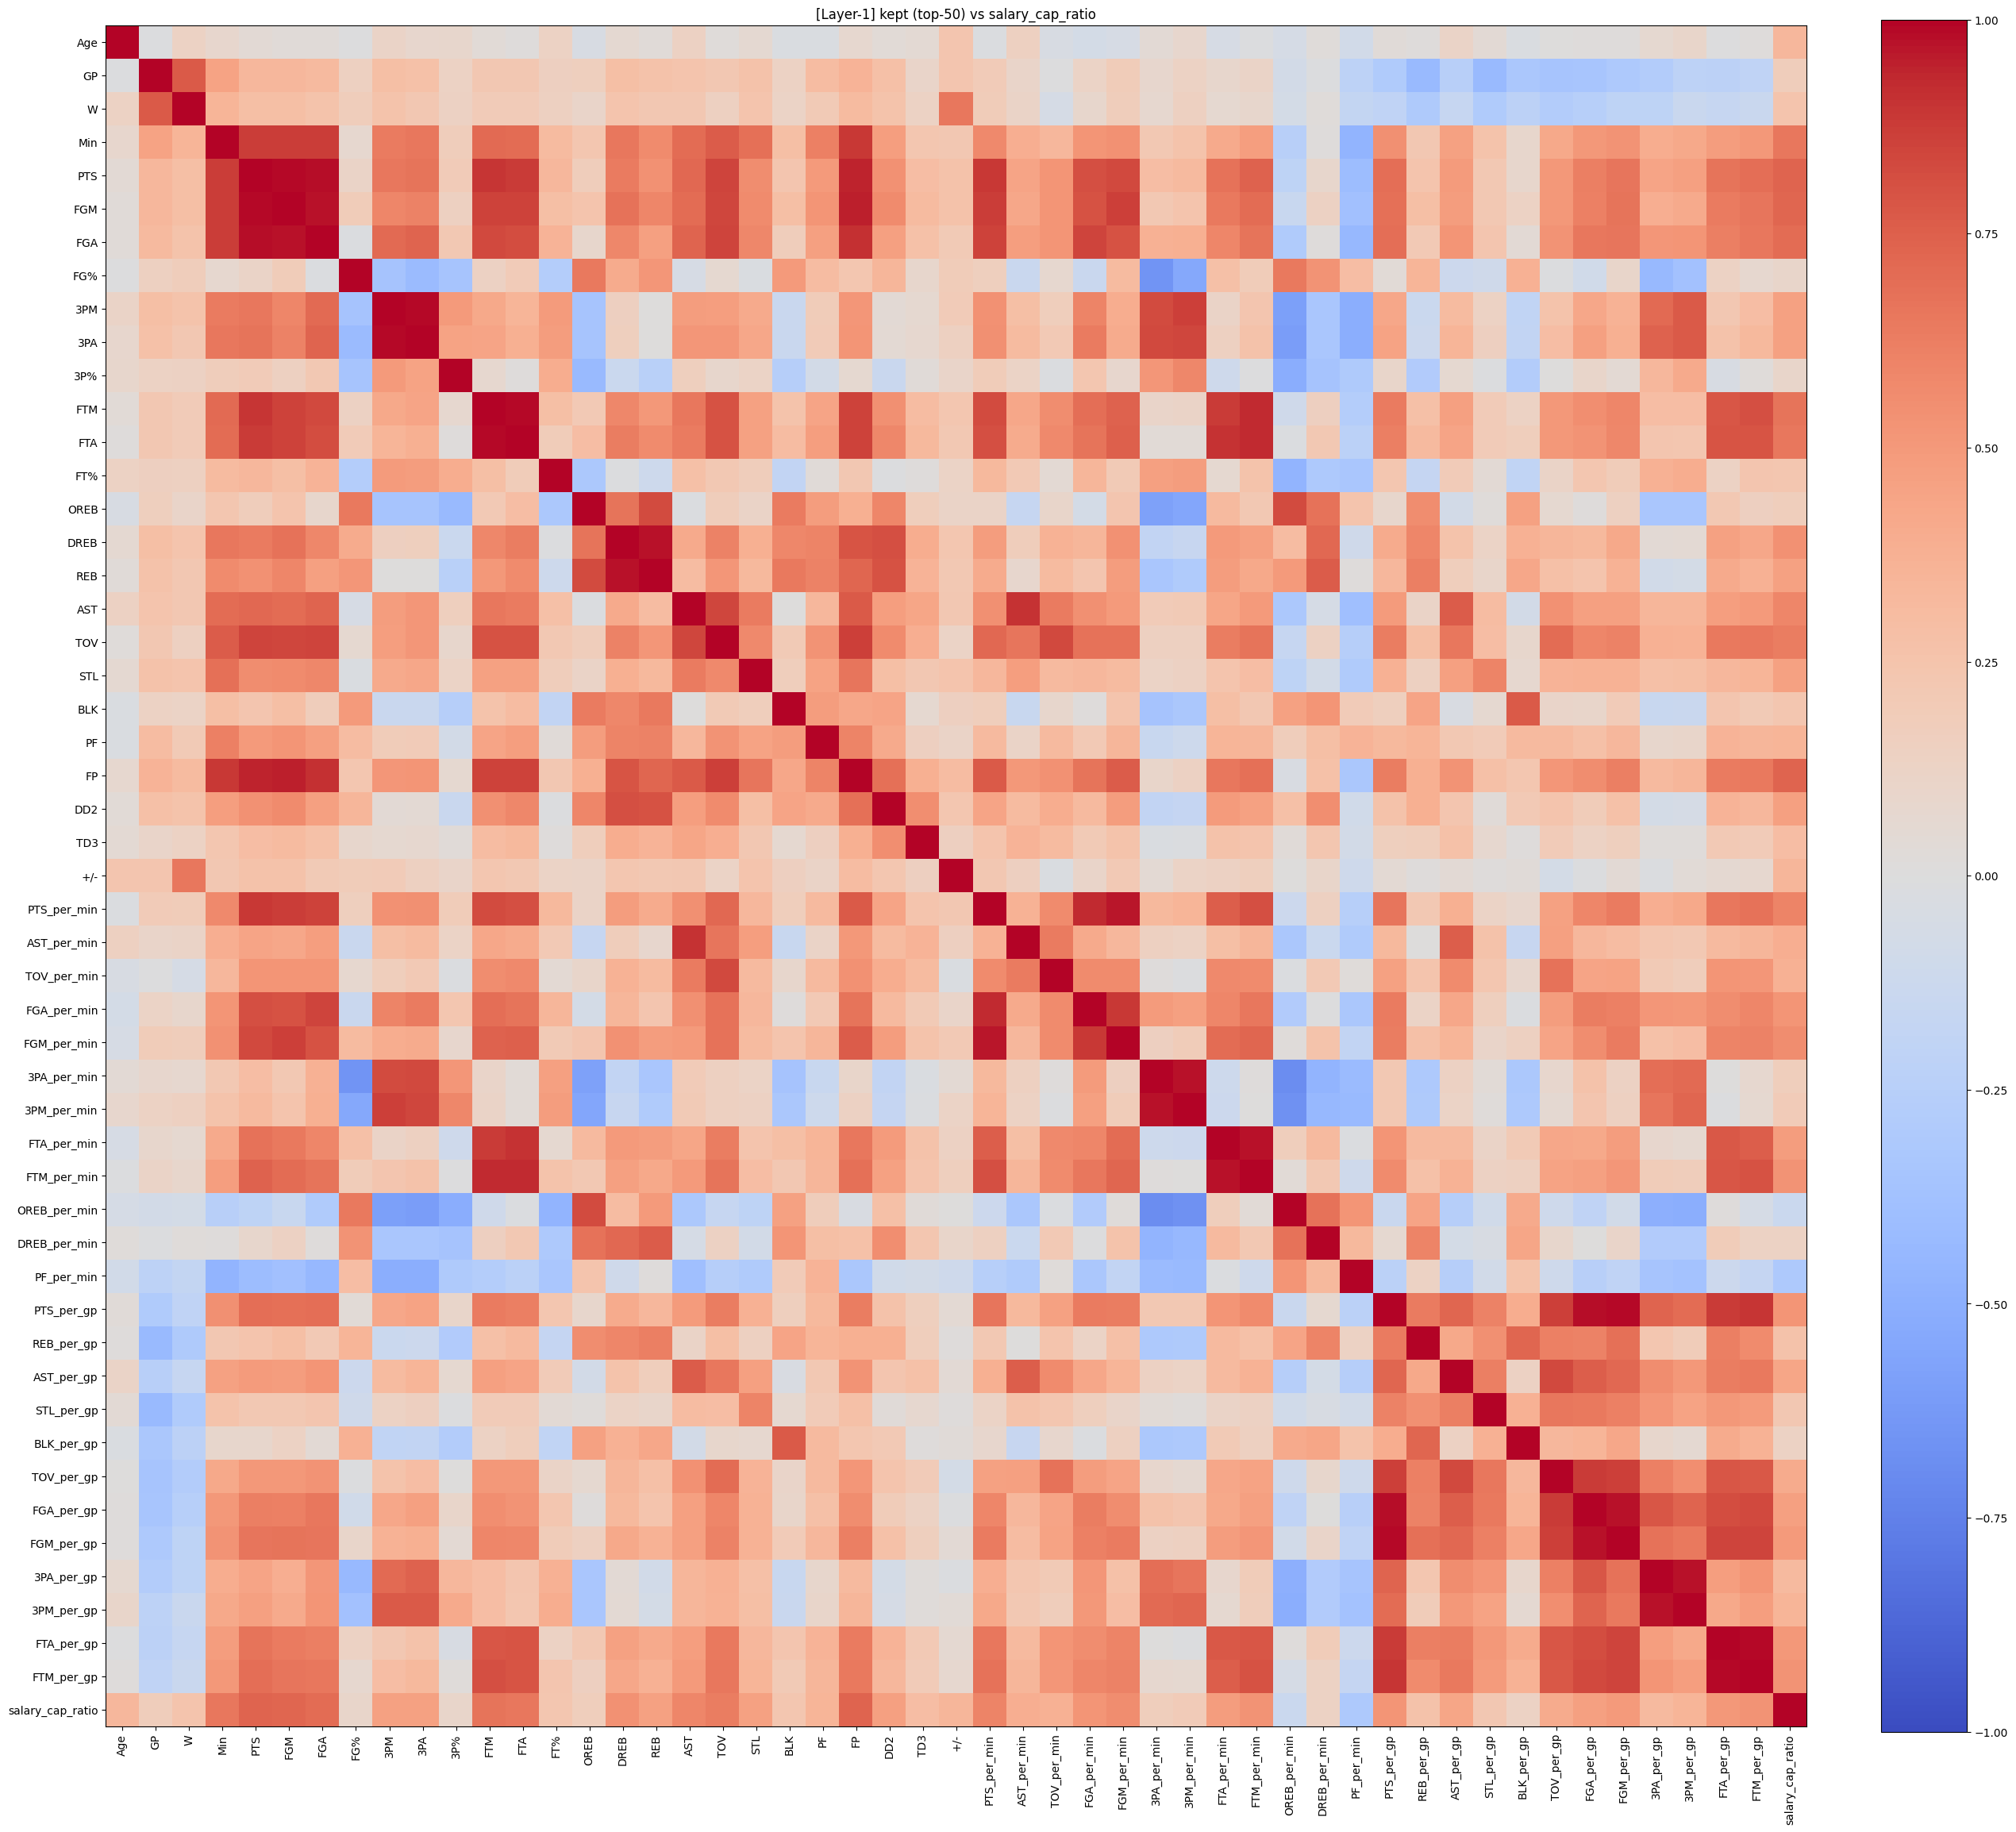

In [50]:
# %%
# ========= 第1层：在“主目标”上做低相关粗筛（可选） =========
feat_after_corr, corr_kept = drop_low_corr_features(
    df, feature_cols_all, target=best_target, thres=MIN_ABS_CORR_TO_TARGET
)
print(f"[Layer-1] 低相关粗筛：从 {len(feature_cols_all)} → {len(feat_after_corr)}  (阈值={MIN_ABS_CORR_TO_TARGET})")
if len(corr_kept) > 0:
    corr_kept.to_csv(REPORT_DIR / f"corr_vs_{best_target}_kept.csv", header=["corr"])

# 可视化（保留集 + 目标）的热力图（前50列上限）
cols_show = feat_after_corr[:min(50, len(feat_after_corr))] + [best_target]
plot_small_heatmap(df[cols_show], f"[Layer-1] kept (top-50) vs {best_target}")


[Layer-1] 低相关粗筛：从 82 → 74  (阈值=0.08)


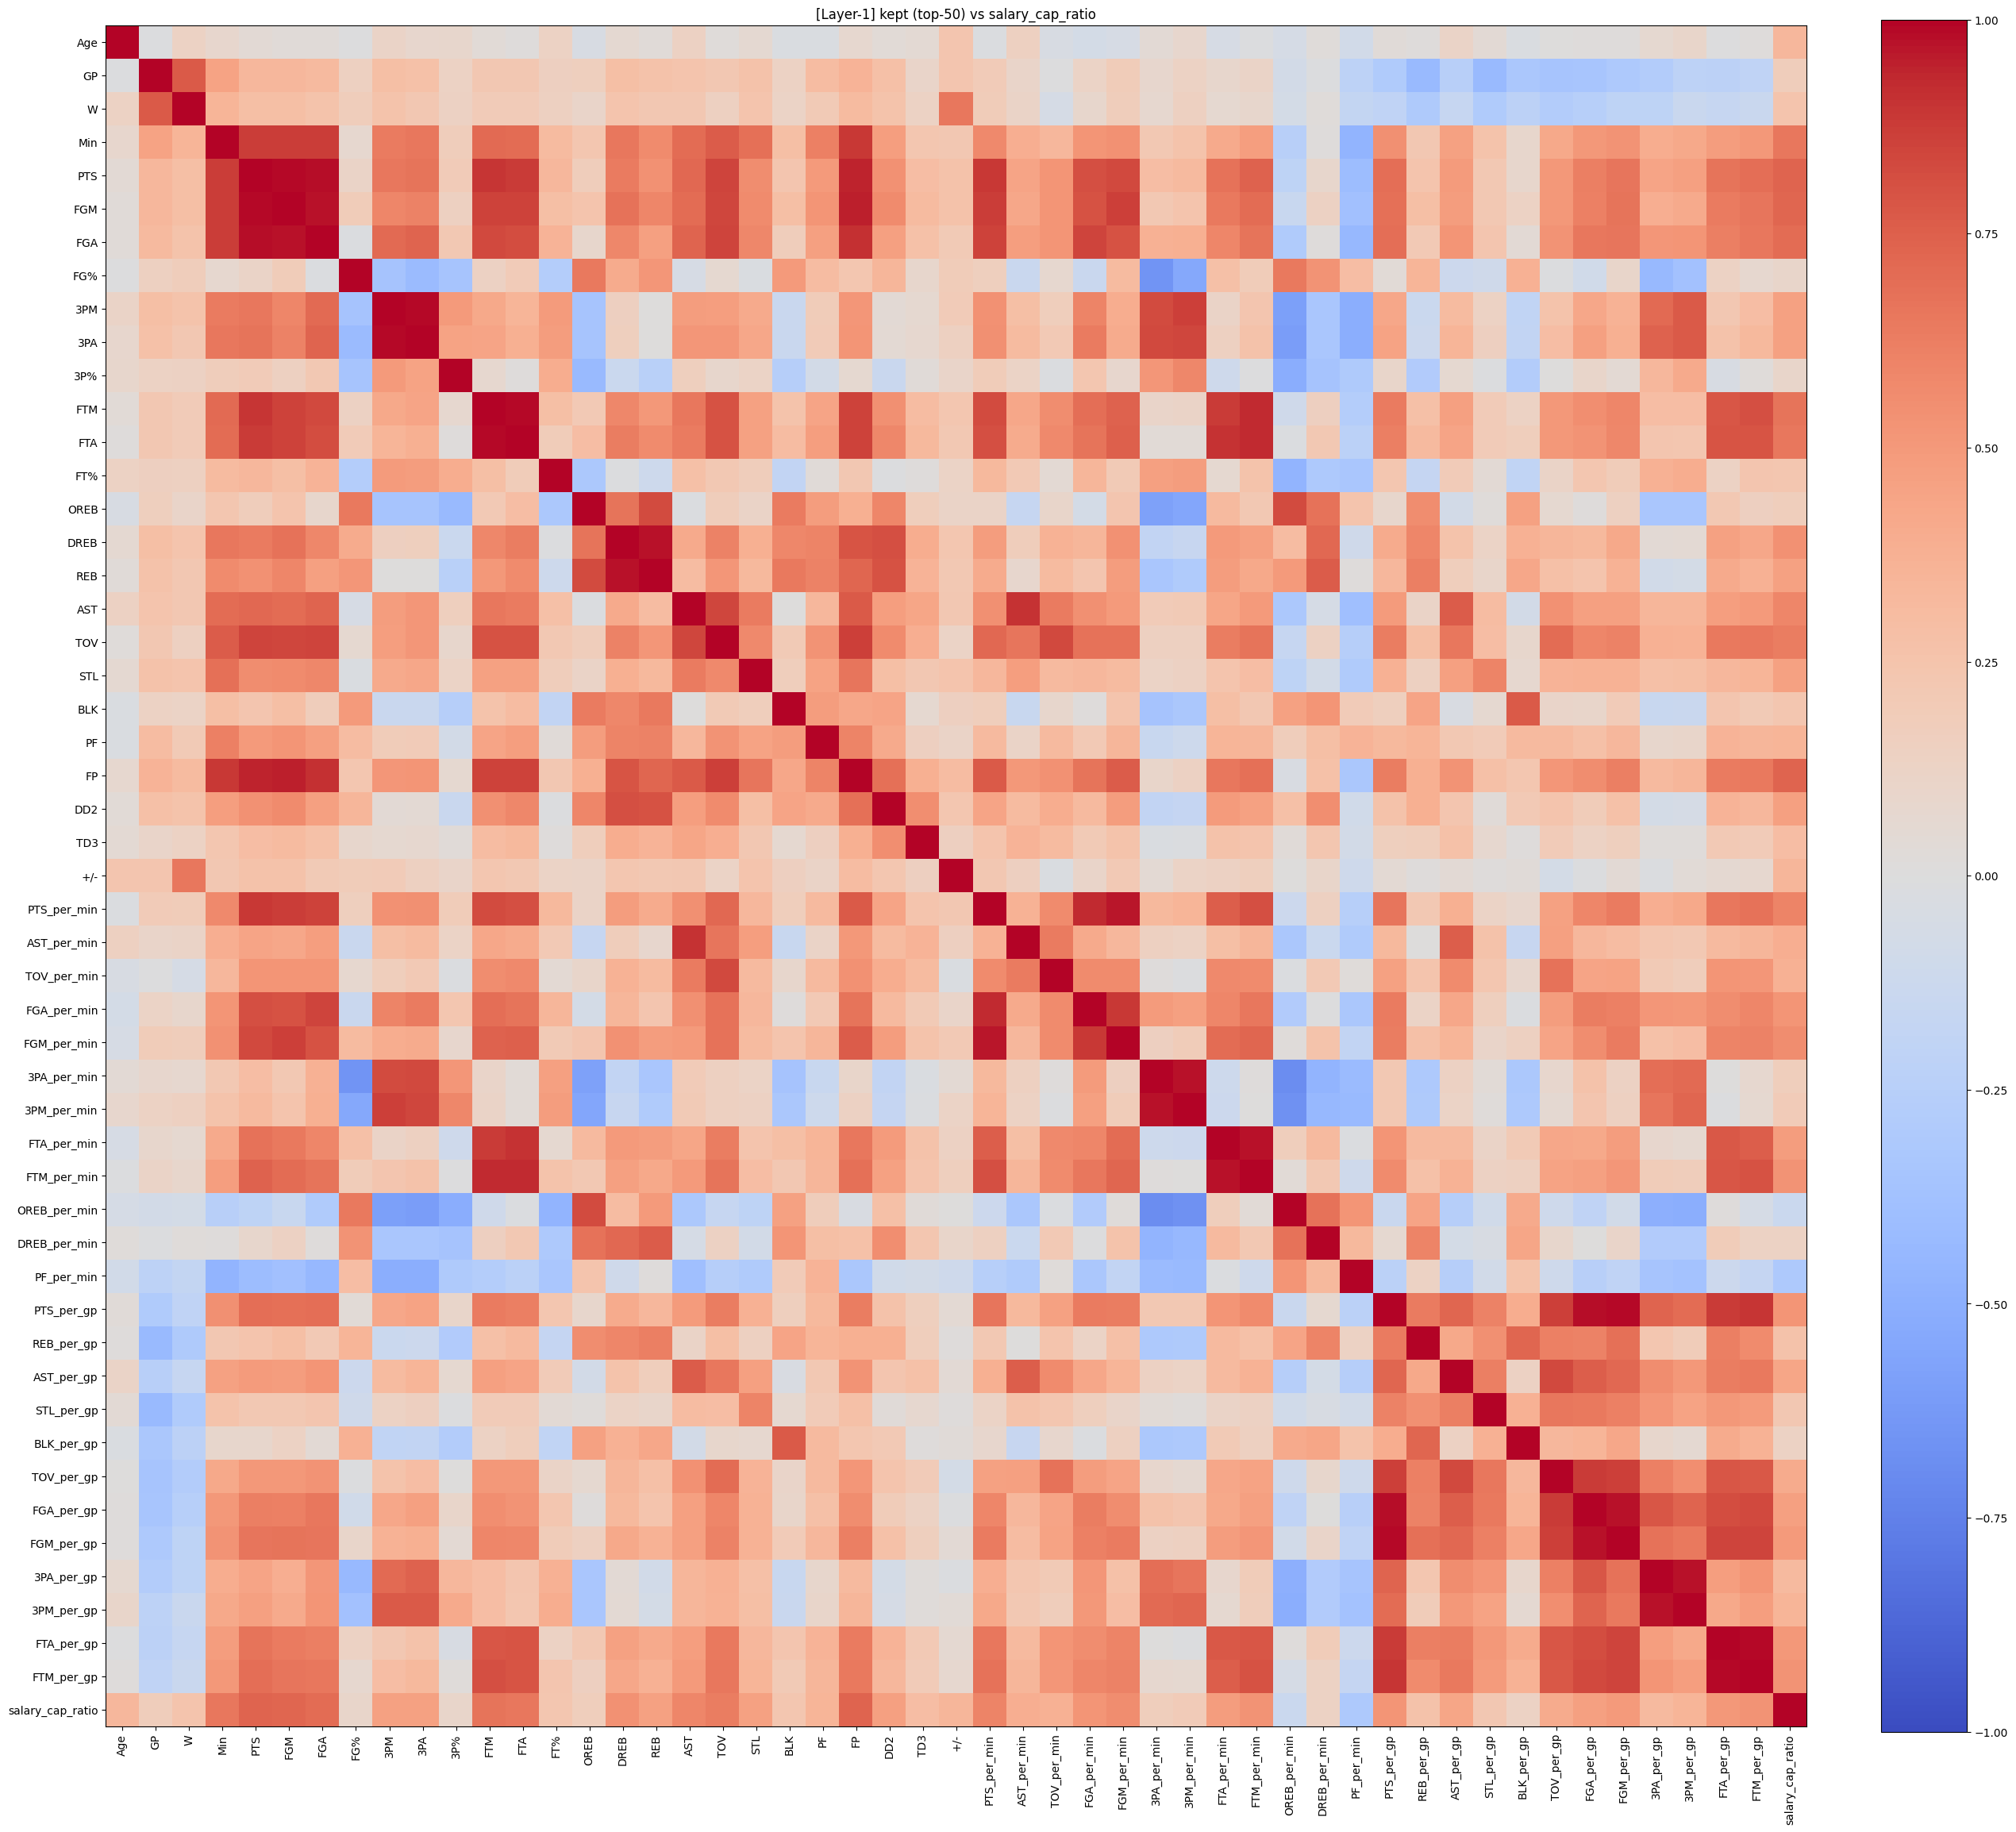

In [51]:
# %%
# ========= 第1层：在“主目标”上做低相关粗筛（可选） =========
feat_after_corr, corr_kept = drop_low_corr_features(
    df, feature_cols_all, target=best_target, thres=MIN_ABS_CORR_TO_TARGET
)
print(f"[Layer-1] 低相关粗筛：从 {len(feature_cols_all)} → {len(feat_after_corr)}  (阈值={MIN_ABS_CORR_TO_TARGET})")
if len(corr_kept) > 0:
    corr_kept.to_csv(REPORT_DIR / f"corr_vs_{best_target}_kept.csv", header=["corr"])

# 可视化（保留集 + 目标）的热力图（前50列上限）
cols_show = feat_after_corr[:min(50, len(feat_after_corr))] + [best_target]
plot_small_heatmap(df[cols_show], f"[Layer-1] kept (top-50) vs {best_target}")


[Saved] reports\features\selected_features.json


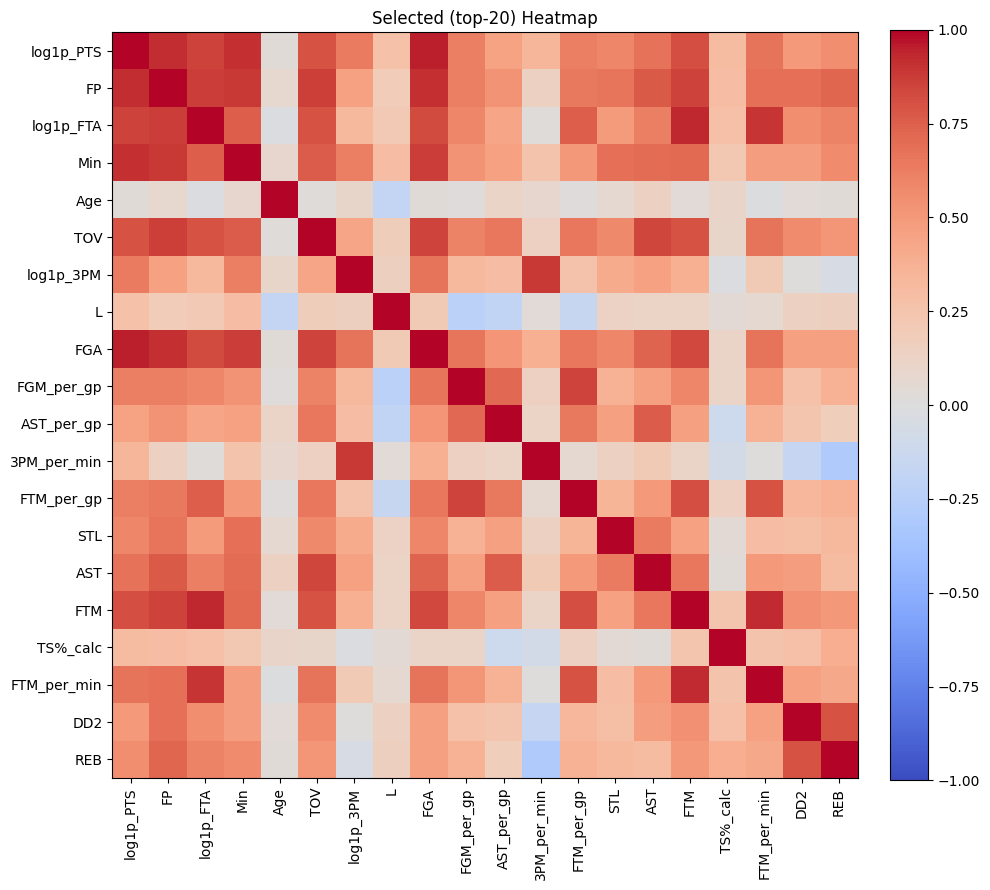

In [52]:
# === Save selection ===
sel_path = REPORT_DIR / "selected_features.json"
with open(sel_path, "w", encoding="utf-8") as f:
    json.dump(selected, f, indent=2, ensure_ascii=False)
print("[Saved]", sel_path)

# 画前 20 个被选特征的相关热力图（检查冗余是否减轻）
top_show = min(20, len(selected))
plot_small_heatmap(df[selected[:top_show]], title="Selected (top-20) Heatmap")

In [53]:
# %%
# ========= 第2层：对“粗筛后的特征”做模型重要性排序 =========
X_main = df[feat_after_corr].copy()
y_main = df[best_target].copy()
_, importances_main, r2_main, rmse_main, model_tag = fit_and_importance(X_main, y_main, use_xgb=USE_XGB)
print(f"[Layer-2:{model_tag}] 主目标={best_target}  R²={r2_main:.4f}  RMSE={rmse_main:.6f}")
display(importances_main.head(20))
importances_main.to_csv(REPORT_DIR / f"feature_importance_{best_target}_after_corrscreen.csv", header=["importance"])


[Layer-2:XGB] 主目标=salary_cap_ratio  R²=0.7855  RMSE=0.043274


FP              0.230893
PTS             0.074755
log1p_PTS       0.034677
Age             0.021380
Min             0.012934
FTA             0.011407
TOV             0.011073
log1p_Min       0.009396
PTS_per_gp      0.008709
log1p_FTM       0.008497
log1p_PF        0.007805
FGM_per_gp      0.007726
log1p_3PM       0.007141
PTS_per_min     0.006592
OREB_per_min    0.006435
FTM             0.006343
DD2             0.006138
FGA             0.005989
AST_per_gp      0.005615
TS%_calc        0.005502
dtype: float64

[Layer-3] 剪枝(full)：40 features (阈值=0.95)


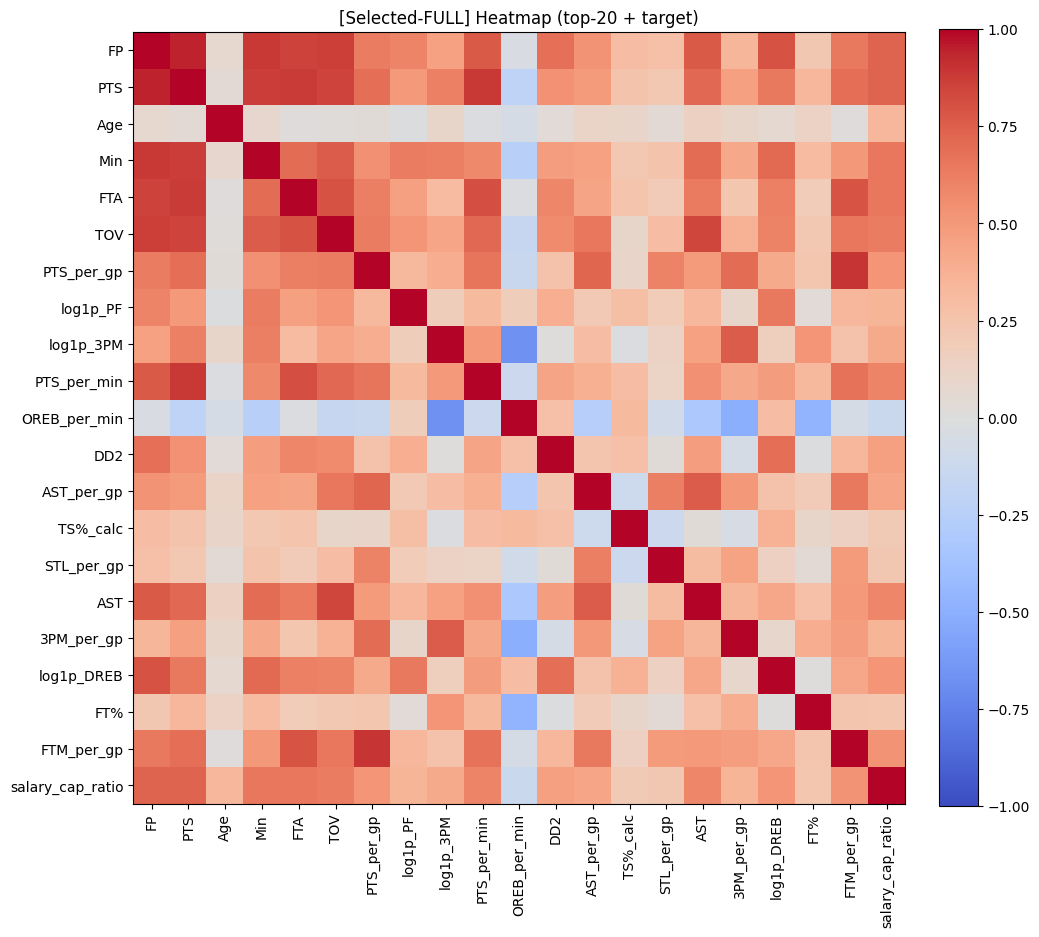

[Layer-3b] 剪枝(core)：10 features


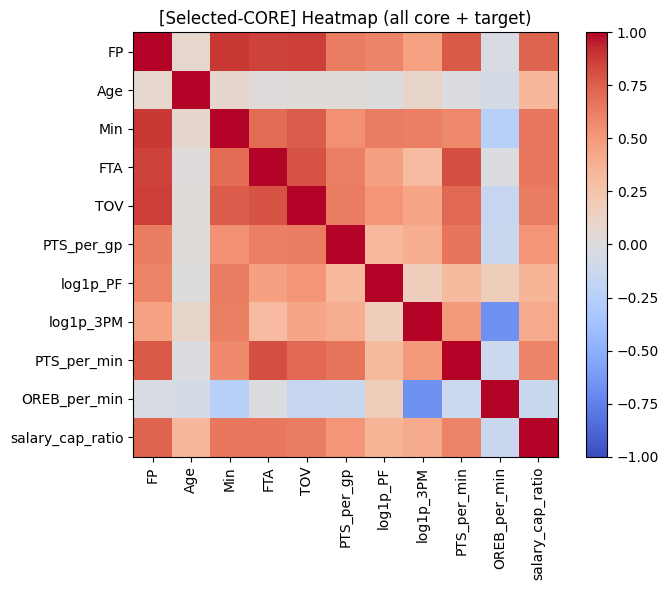

In [54]:
# %%
# ========= 第3层：基于重要性顺序进行相关性剪枝（full 集） =========
ordered = importances_main.index.tolist()
selected_full = correlation_prune(df, ordered, max_keep=FULL_MAX_KEEP, corr_thres=CORR_THRES)
print(f"[Layer-3] 剪枝(full)：{len(selected_full)} features (阈值={CORR_THRES})")
pd.Series(selected_full).to_csv(REPORT_DIR / "selected_features_full.txt", index=False, header=False)

# 诊断热力图（full 的前 20 个）
plot_small_heatmap(df[selected_full[:min(20, len(selected_full))] + [best_target]],
                   "[Selected-FULL] Heatmap (top-20 + target)")

# ========= 生成 core 集（在 full 基础上再严格剪枝） =========
selected_core = correlation_prune(df, selected_full, max_keep=CORE_MAX_KEEP, corr_thres=0.90)
print(f"[Layer-3b] 剪枝(core)：{len(selected_core)} features")
pd.Series(selected_core).to_csv(REPORT_DIR / "selected_features_core.txt", index=False, header=False)

plot_small_heatmap(df[selected_core + [best_target]],
                   "[Selected-CORE] Heatmap (all core + target)")

In [55]:
# %%
# ========= 保存 JSON & 汇总报告 =========
with open(REPORT_DIR / "selected_features_full.json", "w", encoding="utf-8") as f:
    json.dump({"features": selected_full}, f, indent=2, ensure_ascii=False)

with open(REPORT_DIR / "selected_features_core.json", "w", encoding="utf-8") as f:
    json.dump({"features": selected_core}, f, indent=2, ensure_ascii=False)

summary = {
    "data_path": str(DATA_FEAT_PATH),
    "rows": int(df.shape[0]),
    "cols_total": int(df.shape[1]),
    "candidates_total": len(feature_cols_all),
    "auto_best_target": best_target,
    "min_abs_corr_to_target": MIN_ABS_CORR_TO_TARGET,
    "corr_prune_thres_full": CORR_THRES,
    "full_max_keep": FULL_MAX_KEEP,
    "core_max_keep": CORE_MAX_KEEP,
    "use_xgb": USE_XGB,
    "model_target_metrics_csv": "model_target_metrics.csv",
    "importance_after_corrscreen_csv": f"feature_importance_{best_target}_after_corrscreen.csv",
    "selected_full_file": "selected_features_full.json",
    "selected_core_file": "selected_features_core.json",
}

with open(REPORT_DIR / "EDA3_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(json.dumps(summary, indent=2, ensure_ascii=False))
print("✅ Saved:", REPORT_DIR / "EDA3_summary.json")

{
  "data_path": "..\\data\\processed\\training_oncourt_features.parquet",
  "rows": 2082,
  "cols_total": 90,
  "candidates_total": 82,
  "auto_best_target": "salary_cap_ratio",
  "min_abs_corr_to_target": 0.08,
  "corr_prune_thres_full": 0.95,
  "full_max_keep": 40,
  "core_max_keep": 10,
  "use_xgb": true,
  "model_target_metrics_csv": "model_target_metrics.csv",
  "importance_after_corrscreen_csv": "feature_importance_salary_cap_ratio_after_corrscreen.csv",
  "selected_full_file": "selected_features_full.json",
  "selected_core_file": "selected_features_core.json"
}
✅ Saved: reports\features\EDA3_summary.json
